In [1581]:
!wget https://raw.githubusercontent.com/yuchen118125/data/master/KHC.csv

--2020-04-23 17:34:22--  https://raw.githubusercontent.com/yuchen118125/data/master/KHC.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78152 (76K) [text/plain]
Saving to: ‘KHC.csv.3’

KHC.csv.3           100%[===================>]  76.32K  --.-KB/s    in 0.02s   

2020-04-23 17:34:22 (3.20 MB/s) - ‘KHC.csv.3’ saved [78152/78152]



In [1582]:
import pandas as pd
import numpy as np
import datetime
import tqdm #進度條
import talib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
data = pd.read_csv('KHC.csv')
data1 = pd.read_csv("data/1019_CL.csv").dropna()
data2 = pd.read_csv("data/1019_OVX.csv").dropna()
data3 = pd.read_csv("data/1019_GC.csv").dropna()
data4 = pd.read_csv("data/1019_GVZ.csv").dropna()
Date = data.get("Date")
Date = pd.to_datetime(Date)
Open = data.get("Open")
High = data.get("High")
Low = data.get("Low")
Close = data.get("Close")
Close_cl = data1.get("Close")
Close_ovx = data2.get("Close")
Close_gc = data3.get("Close")
Close_gvz = data4.get("Close")

dict = {"Date": Date,
        "open": Open,
        "high": High,
        "low": Low, 
        "close": Close,
        "close_cl": Close_cl, 
        "close_ovx": Close_ovx,
        "close_gc": Close_gc, 
        "close_gvz": Close_gvz,
        "return":0,
       }
df = pd.DataFrame(dict)
df.set_index('Date', inplace=True)
df = df.dropna()
print("總共:%d個交易時間點" % (len(Date)))
print("去除空白值後剩下:%d個交易時間點" % (len(df)))
df.tail(10)

總共:1131個交易時間點
去除空白值後剩下:1131個交易時間點


,open,high,low,close,close_cl,close_ovx,close_gc,close_gvz,return
Date,,,,,,,,,
2019-12-16,31.760000,32.000000,31.549999,31.740000,105.370003,16.520000,1321.800049,14.01,0
2019-12-17,31.690001,31.784000,31.355000,31.620001,105.339996,16.240000,1326.400024,13.74,0
2019-12-18,31.700001,31.900000,31.624001,31.750000,104.480003,15.870000,1330.699951,13.89,0
2019-12-19,31.860001,32.110001,31.610001,31.900000,103.529999,16.360001,1316.500000,12.99,0
2019-12-20,32.029999,32.250000,31.780001,32.220001,103.400002,16.309999,1316.000000,12.83,0
2019-12-23,32.200001,32.299999,31.820000,31.920000,102.290001,16.360001,1323.800049,13.05,0
2019-12-24,31.930000,32.080002,31.865000,31.980000,102.930000,16.459999,1338.699951,12.91,0
2019-12-26,31.950001,31.980000,31.500000,31.629999,100.830002,17.260000,1337.000000,13.27,0
2019-12-27,31.719999,31.885000,31.530001,31.620001,100.910004,18.100000,1306.300049,14.23,0


In [ ]:
def create_labels(df,col_name,window_size=11):
  row_counter = 0
  total_rows = len(df)
  labels = np.zeros(total_rows)
  labels[:]=np.nan
  while row_counter <total_rows:
    if row_counter>=window_size-1:
      window_begin=row_counter-(window_size-1)
      window_end=row_counter
      window_middle=(window_begin+window_end)/2
      min_=np.inf
      min_index=-1
      max_=-np.inf
      max_index=-1
      for i in range(window_begin,window_end+1):
        price = df.iloc[i][col_name]
        if price<min_:
          min_=price
          min_index=i
        elif price>max_:
          max_=price
          max_index=i
      if max_index == window_middle:
        labels[row_counter] = 2
      elif min_index == window_middle:
        labels[row_counter] = 0
      else:
        labels[row_counter] = 1
    row_counter = row_counter+1
  return labels
df['return'] = create_labels(df,'close')

In [ ]:
ema = talib.EMA(df['close'])
sma = talib.SMA(df['close'])
roc = talib.ROC(df['close'])
macd, macdsignal, macdhist = talib.MACD(df['close'])
k, d = talib.STOCH (df['high'], df['low'], df['close'])
upper, middle, lower = talib.BBANDS(df['close'])
B = (df['close'] - lower)/(upper - lower)

dataset = pd.DataFrame({
    'Close':df['close'],    
    'EMA':ema,
    'SMA':sma,
    'ROC':roc,
    'MACD':macd,
    '%K':k,
    '%D':d,
    'Upper Band':upper,
    'Lower Band':lower,
    '%B':B,
    'Close_CL':df['close_cl'],
    'Close_OVX':df['close_ovx'],
    'Close_GC':df['close_gc'],
    'Close_GVZ':df['close_gvz'],
    'return': df['return'],
})

feature_names = list(dataset.columns[:-1])

In [1585]:
print("before dropping NaN", dataset.shape)
dataset = dataset.dropna()
print("after dropping NaN", dataset.shape)

before dropping NaN (1131, 15)
after dropping NaN (1098, 15)


In [1586]:
from sklearn.preprocessing import MinMaxScaler

ss = MinMaxScaler()

dataset_scaled = ss.fit_transform(dataset)
dataset_scaled = pd.DataFrame(dataset_scaled, columns=dataset.columns, index=dataset.index)
dataset_scaled['return'] = dataset['return']
dataset_scaled.describe()

,Close,EMA,SMA,ROC,MACD,%K,%D,Upper Band,Lower Band,%B,Close_CL,Close_OVX,Close_GC,Close_GVZ,return
count,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000
mean,0.574590,0.613382,0.614138,0.618302,0.603598,0.510439,0.498530,0.569231,0.596482,0.488932,0.550588,0.329177,0.462277,0.280601,1.021858
std,0.298435,0.323558,0.321039,0.104311,0.163023,0.258640,0.247158,0.291982,0.308370,0.288094,0.207178,0.179438,0.244658,0.169707,0.383663
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.365178,0.408202,0.417798,0.573952,0.507658,0.287811,0.295344,0.372883,0.387885,0.242087,0.400425,0.179047,0.257155,0.161991,1.000000
50%,0.677250,0.726252,0.730308,0.627602,0.624687,0.502265,0.494563,0.674906,0.688773,0.482210,0.572844,0.342773,0.405762,0.253038,1.000000
75%,0.835101,0.892633,0.889710,0.670502,0.710613,0.725212,0.700850,0.820555,0.859990,0.751280,0.707045,0.415628,0.688039,0.361240,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


1.0    936
2.0     93
0.0     69
Name: return, dtype: int64


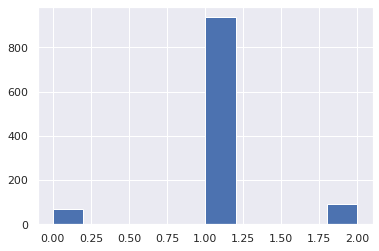

In [1587]:
result = pd.value_counts(dataset_scaled['return'])
print(result)
dataset_scaled['return'].hist()

In [1588]:
from keras.utils import np_utils
#每張圖包含幾天的資料
time_period = 20
#預設幾日後的漲跌
day = 1

cnn_x = []
cnn_y = []
indexs = []
dataset_scaled_x= dataset_scaled[feature_names]

for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-time_period-1-day)):
    cnn_x.append(dataset_scaled_x.iloc[i:i+time_period].values)
    r = dataset_scaled['return'].iloc[i+time_period-1+day]
    rr = np_utils.to_categorical(r, num_classes=3)
    cnn_y.append(rr)
    indexs.append(dataset_scaled.index[i+time_period-1])
    
cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [ ]:
#2010~2018年為訓練和測試，2019年則為驗證
import datetime
cnn_x_t = cnn_x[indexes < datetime.datetime(2019,1,1)]
cnn_y_t = cnn_y[indexes < datetime.datetime(2019,1,1)]
cnn_x_validation = cnn_x[indexes > datetime.datetime(2019,1,1)]
cnn_y_validation = cnn_y[indexes > datetime.datetime(2019,1,1)]

In [ ]:
from sklearn.model_selection import train_test_split
cnn_x_train, cnn_x_test, cnn_y_train, cnn_y_test = train_test_split(cnn_x_t, cnn_y_t, 
                                                                    test_size=0.2,
                                                                    random_state =1,
                                                                    stratify=cnn_y_t,
                                                                    shuffle = True)

In [ ]:
cnn_x_train = np.stack((cnn_x_train,)*3,axis=-1)
cnn_x_test = np.stack((cnn_x_test,)*3,axis=-1)
cnn_x_validation = np.stack((cnn_x_validation,)*3,axis=-1)

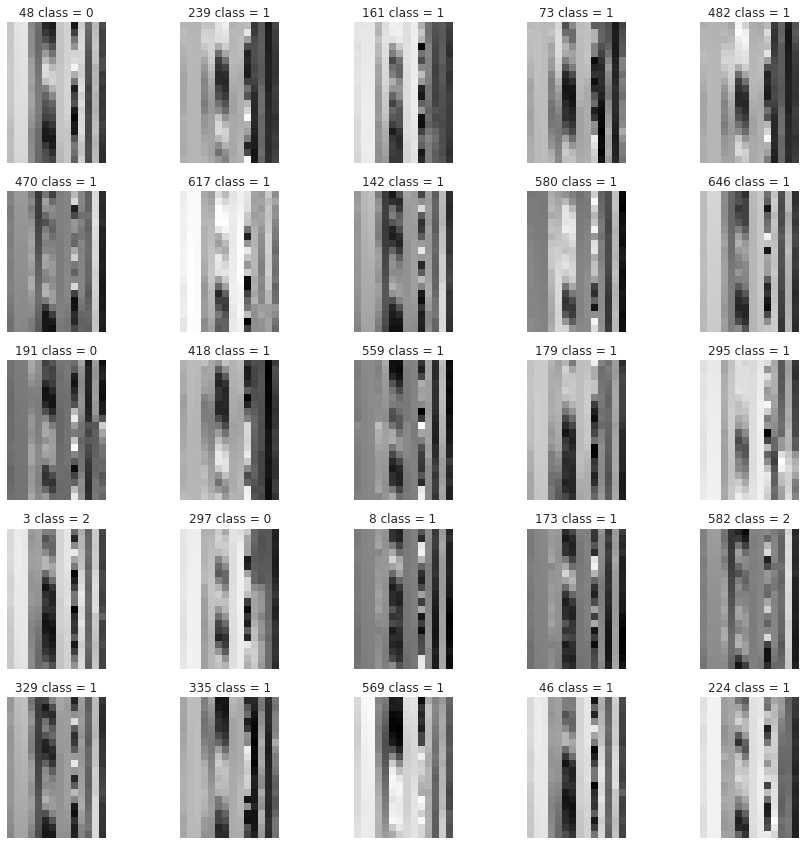

In [1592]:
fig = plt.figure(figsize = (15,15))
columns = rows = 5
for i in range(1,columns*rows+1):
  index = np.random.randint(len(cnn_x_train))
  img = cnn_x_train[index]
  fig.add_subplot(rows,columns,i)
  plt.axis("off")
  plt.title(str(index)+' class = '+str(np.argmax(cnn_y_train[index])))
  plt.subplots_adjust(wspace=0.2,hspace=0.2)
  plt.imshow(img)
plt.show()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
def get_sample_weights(y):
  y = y.astype(int)
  class_weight = compute_class_weight('balanced',np.unique(y),y)
  print("real class weight are{}".format(class_weight),np.unique(y))
  print("value_counts",np.unique(y,return_counts=True))
  sample_weights = y.copy().astype(float)
  for i in np.unique(y):
    sample_weights[sample_weights==i]=class_weight[i]
  return class_weight,sample_weights

In [1594]:
#將onehot編碼轉回數組
lable = np.argmax(cnn_y_train, axis=1)
lable = np.array(lable)
class_weight,sample_weights = get_sample_weights(lable)

real class weight are[5.13178295 0.3919479  3.94047619] [0 1 2]
value_counts (array([0, 1, 2]), array([ 43, 563,  56]))


In [1595]:
class_weight={0:class_weight[0],
              1:class_weight[1],
              2:class_weight[2],}
print(class_weight)

{0: 5.131782945736434, 1: 0.3919478981645944, 2: 3.9404761904761907}


In [ ]:
import tensorflow.keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal

input_shape = cnn_x_train[0].shape

def get_model(dropout1_rate=0.5, dropout2_rate=0.5):
    model = Sequential()
    model.add(layers.Conv2D(filters=32, 
                            kernel_size=(3,3), 
                            activation='relu',
                            padding="same",
                            input_shape=input_shape))
    model.add(layers.Conv2D(filters=64, 
                            kernel_size=(3,3), 
                            padding="same", 
                            activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(dropout1_rate, name="dropout_1"))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=128, activation='relu'))
    model.add(layers.Dropout(dropout2_rate, name="dropout_2"))
    model.add(layers.Dense(units=3, activation='softmax'))
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping 
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

def fit_with(dropout1_rate, dropout2_rate, lr, batchsize):

    # batchsize只能是整數，強迫把浮點轉int
    batchsize = int(batchsize)

    # 使用指定的超參數創建模型。
    model = get_model(dropout1_rate, dropout2_rate)
    
    # 設定優化器、學習率並建模
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    
    # 使用訓練數據集訓練模型。
    model.fit(cnn_x_train, cnn_y_train,
              batch_size = batchsize,
              epochs=250,
              verbose=0,
              validation_data=(cnn_x_test,cnn_y_test),
              callbacks=[earlystop],
              class_weight=class_weight,
              )
    # steps=10 = 評估階段結束之前的步驟總數（樣本批次）
    # score = model.evaluate(cnn_x_test,cnn_y_test, steps=10, verbose=0)
    # 使用測試數據集評估模型。
    score = model.evaluate(cnn_x_test, cnn_y_test, verbose=0)
    #print('Test loss:', score[0])
    #print('Test accuracy:', score[1])

    return score[1]

In [1564]:
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(
        fit_with,
        {'dropout1_rate': (0, 0.5),
        'dropout2_rate': (0, 0.5),
        'lr': (1e-5, 1e-2),
        'batchsize': (16,128)}
    )
optimizer.maximize(init_points=10, n_iter=20)

|   iter    |  target   | batchsize | dropou... | dropou... |    lr     |
-------------------------------------------------------------------------
Epoch 00021: early stopping
|  1        |  0.5241   |  43.6     |  0.3417   |  0.3355   |  0.003684 |
Epoch 00015: early stopping
|  2        |  0.5241   |  60.87    |  0.2795   |  0.1794   |  0.004441 |
Epoch 00015: early stopping
|  3        |  0.06627  |  53.38    |  0.3131   |  0.001867 |  0.009381 |
Epoch 00041: early stopping
|  4        |  0.7349   |  67.37    |  0.09874  |  0.3987   |  0.002899 |
Epoch 00027: early stopping
|  5        |  0.6566   |  69.84    |  0.144    |  0.244    |  0.001506 |
Epoch 00064: early stopping
|  6        |  0.7651   |  124.4    |  0.1133   |  0.2936   |  0.001532 |
Epoch 00014: early stopping
|  7        |  0.06627  |  26.51    |  0.06252  |  0.3207   |  0.009232 |
Epoch 00041: early stopping
|  8        |  0.5542   |  84.11    |  0.3849   |  0.4417   |  0.003174 |
Epoch 00038: early stopping
|  9    

In [1565]:
print(optimizer.max)
print(optimizer.max['params']['dropout1_rate'])
print(optimizer.max['params']['dropout2_rate'])
print(optimizer.max['params']['lr'])
print(optimizer.max['params']['batchsize'])
##Bayesian Optimization 找到的最佳超參數值
dropout_rate1 = optimizer.max['params']['dropout1_rate']
dropout_rate2 = optimizer.max['params']['dropout2_rate']
learning_rate = optimizer.max['params']['lr']
batchsize = int(optimizer.max['params']['batchsize'])

{'target': 0.849397599697113, 'params': {'batchsize': 105.6583944016328, 'dropout1_rate': 0.0, 'dropout2_rate': 0.5, 'lr': 0.01}}
0.0
0.5
0.01
105.6583944016328


In [ ]:
dropout_rate1 = 0.4638
dropout_rate2 = 0.04089
learning_rate =  0.001952
batchsize = int(69.01)

In [1597]:
import tensorflow.keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal

input_shape = cnn_x_train[0].shape

model = Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu',
                        padding="same",
                        input_shape=input_shape))
model.add(layers.Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        padding="same", 
                        activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(dropout_rate1, name="dropout_1"))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(dropout_rate2, name="dropout_2"))
model.add(layers.Dense(units=3, activation='softmax'))

adam = tensorflow.keras.optimizers.Adam(learning_rate)

model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])
print(model.summary())

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_160 (Conv2D)          (None, 20, 14, 32)        896       
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 20, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 10, 7, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 7, 64)         0         
_________________________________________________________________
flatten_80 (Flatten)         (None, 4480)              0         
_________________________________________________________________
dense_160 (Dense)            (None, 128)               573568    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)             

In [1598]:
from tensorflow.keras.callbacks import EarlyStopping 
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=batchsize,
                    epochs=250,
                    verbose=1,
                    validation_data=(cnn_x_test,cnn_y_test),
                    callbacks=[earlystop],
                    #sample_weight=sample_weights,
                    class_weight=class_weight,
                    )

Epoch 1/250
10/10 [==============================] - 1s 96ms/step - loss: 1.1714 - accuracy: 0.2779 - val_loss: 0.9065 - val_accuracy: 0.8494
Epoch 2/250
10/10 [==============================] - 1s 81ms/step - loss: 1.1139 - accuracy: 0.8218 - val_loss: 1.0879 - val_accuracy: 0.4759
Epoch 3/250
10/10 [==============================] - 1s 83ms/step - loss: 1.0867 - accuracy: 0.2115 - val_loss: 1.0725 - val_accuracy: 0.1084
Epoch 4/250
10/10 [==============================] - 1s 82ms/step - loss: 1.0502 - accuracy: 0.2946 - val_loss: 1.0566 - val_accuracy: 0.3614
Epoch 5/250
10/10 [==============================] - 1s 81ms/step - loss: 0.9794 - accuracy: 0.4864 - val_loss: 1.0610 - val_accuracy: 0.1928
Epoch 6/250
10/10 [==============================] - 1s 85ms/step - loss: 0.8720 - accuracy: 0.3112 - val_loss: 0.9557 - val_accuracy: 0.4277
Epoch 7/250
10/10 [==============================] - 1s 80ms/step - loss: 0.7756 - accuracy: 0.4879 - val_loss: 1.1173 - val_accuracy: 0.2711
Epoch 

In [1599]:
o_loss,o_accuracy = model.evaluate(cnn_x_train,cnn_y_train)
print("對訓練資料的：\nLoss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
n_loss,n_accuracy = model.evaluate(cnn_x_test,cnn_y_test)
print("對測試資料的：\nLoss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))

21/21 [==============================] - 0s 11ms/step - loss: 0.2689 - accuracy: 0.8822
對訓練資料的：
Loss: 0.27, Accuracy: 0.88
6/6 [==============================] - 0s 9ms/step - loss: 0.4973 - accuracy: 0.7410
對測試資料的：
Loss: 0.50, Accuracy: 0.74


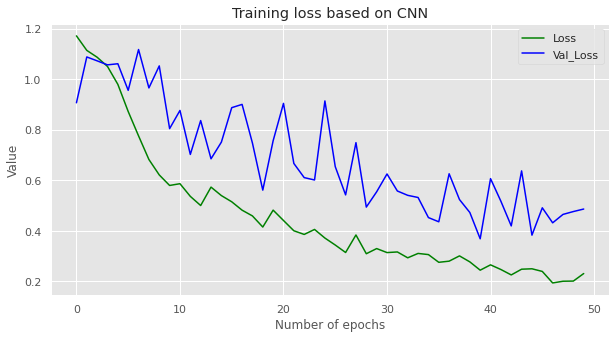

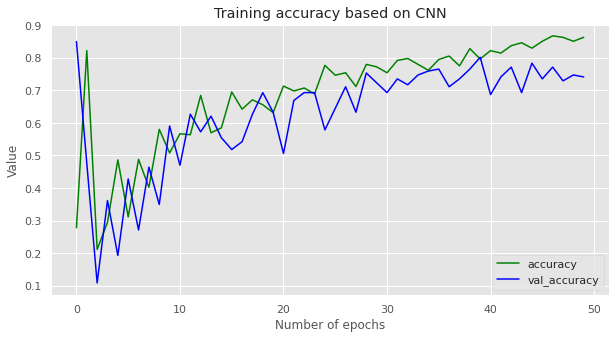

In [1600]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], color = 'green', label='Loss')
plt.plot(history.history['val_loss'], color = 'blue', label='Val_Loss')
plt.legend()
plt.title('Training loss based on CNN')
plt.ylabel('Value')
plt.xlabel('Number of epochs')
plt.show()
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], color = 'green', label='accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label='val_accuracy')
plt.legend()
plt.title('Training accuracy based on CNN')
plt.ylabel('Value')
plt.xlabel('Number of epochs')
plt.show()

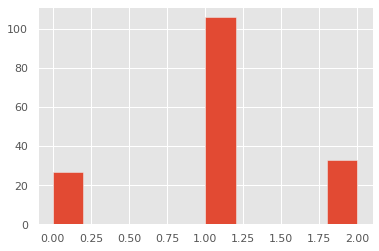

In [1601]:
#將onehot編碼轉回數組
cnn_y_test = np.argmax(cnn_y_test, axis=1)
xcnn_y_test = pd.Series(cnn_y_test)
#預測測試集
pre = model.predict_classes(cnn_x_test)
pre = pd.Series(pre)
pre.hist()

對訓練集資料的：Loss: 0.27, Accuracy: 0.88
對測試集資料的：Loss: 0.50, Accuracy: 0.74

測試資料總共：166.00 筆
其中 Buy 的筆數為: 14.00, 全部猜 Buy 猜對的機率是: 0.08
其中 Hold 的筆數為: 141.00, 全部猜 Hold 猜對的機率是: 0.85
其中 Sell 的筆數為: 11.00, 全部猜 Sell 猜對的機率是: 0.07

該測試集資料的 Accuracy 為: 0.74 
Precision(Buy): 0.33, Recall(Buy): 0.82, F1 score(Buy): 0.47
Precision(Hold): 0.96, Recall(Hold): 0.72, F1 score(Hold): 0.83
Precision(Sell): 0.36, Recall(Sell): 0.86, F1 score(Sell): 0.51


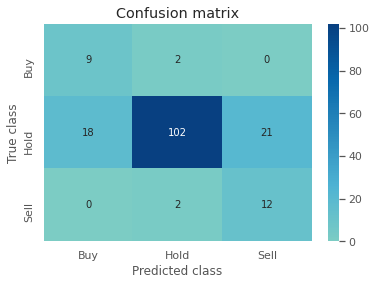

In [1602]:
from sklearn.metrics import confusion_matrix

LABELS = ["Buy","Hold","Sell"]
conf_matrix = confusion_matrix(xcnn_y_test, pre)
#原始資料
t_size = len(cnn_y_test)
b_size = (cnn_y_test>=2).sum()
s_size = (cnn_y_test<=0).sum()
h_size = t_size-(b_size+s_size)
b_guess = b_size/t_size
s_guess = s_size/t_size
h_guess = h_size/t_size
#矩陣數字
c00 = conf_matrix[0][0]
c01 = conf_matrix[0][1]
c02 = conf_matrix[0][2]
c10 = conf_matrix[1][0]
c11 = conf_matrix[1][1]
c12 = conf_matrix[1][2]
c20 = conf_matrix[2][0]
c21 = conf_matrix[2][1]
c22 = conf_matrix[2][2]
#評估指標
accuracy = (c00+c11+c22)/t_size
precision_b = c00/(c00+c10+c20)
precision_h = c11/(c01+c11+c21)
precision_s = c22/(c02+c12+c22)
recall_b = c00/(c00+c01+c02)
recall_h = c11/(c10+c11+c12)
recall_s = c22/(c20+c21+c22)
F1_b = 2*((precision_b*recall_b)/(precision_b+recall_b))
F1_h = 2*((precision_h*recall_h)/(precision_h+recall_h))
F1_s = 2*((precision_s*recall_s)/(precision_s+recall_s))
#印出
print("對訓練集資料的：Loss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
print("對測試集資料的：Loss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))
print("\n測試資料總共：%.2f 筆\n其中 Buy 的筆數為: %.2f, 全部猜 Buy 猜對的機率是: %.2f" % (t_size, b_size, b_guess))
print("其中 Hold 的筆數為: %.2f, 全部猜 Hold 猜對的機率是: %.2f" % (h_size, h_guess))
print("其中 Sell 的筆數為: %.2f, 全部猜 Sell 猜對的機率是: %.2f" % (s_size, s_guess))
print("\n該測試集資料的 Accuracy 為: %.2f \nPrecision(Buy): %.2f, Recall(Buy): %.2f, F1 score(Buy): %.2f" % (accuracy, precision_b, recall_b, F1_b))
print("Precision(Hold): %.2f, Recall(Hold): %.2f, F1 score(Hold): %.2f" % (precision_h, recall_h, F1_h))
print("Precision(Sell): %.2f, Recall(Sell): %.2f, F1 score(Sell): %.2f" % (precision_s, recall_s, F1_s))
#畫圖
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",center=0.7,cmap = 'GnBu');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

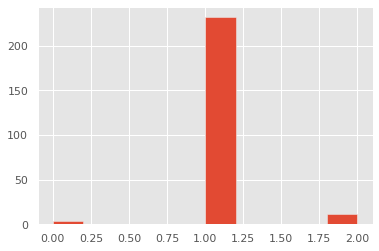

In [1603]:
#將onehot編碼轉回數組cnn_x_validation
cnn_y_validation = np.argmax(cnn_y_validation, axis=1)
xcnn_y_validation = pd.Series(cnn_y_validation)
#預測
pre = model.predict_classes(cnn_x_validation)
pre = pd.Series(pre)
pre.hist()

對訓練集資料的：Loss: 0.27, Accuracy: 0.88
對測試集資料的：Loss: 0.50, Accuracy: 0.74

驗證資料總共：248.00 筆
其中 Buy 的筆數為: 21.00, 全部猜 Buy 猜對的機率是: 0.08
其中 Hold 的筆數為: 213.00, 全部猜 Hold 猜對的機率是: 0.86
其中 Sell 的筆數為: 14.00, 全部猜 Sell 猜對的機率是: 0.06

該測試集資料的 Accuracy 為: 0.88 
Precision(Buy): 0.25, Recall(Buy): 0.07, F1 score(Buy): 0.11
Precision(Hold): 0.89, Recall(Hold): 0.97, F1 score(Hold): 0.93
Precision(Sell): 0.75, Recall(Sell): 0.43, F1 score(Sell): 0.55


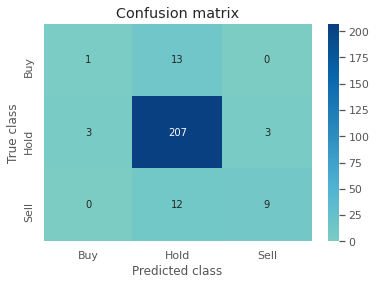

In [1604]:
from sklearn.metrics import confusion_matrix

LABELS = ["Buy","Hold","Sell"]
conf_matrix = confusion_matrix(xcnn_y_validation, pre)

#原始資料
t_size = len(cnn_y_validation)
b_size = (cnn_y_validation>=2).sum()
s_size = (cnn_y_validation<=0).sum()
h_size = t_size-(b_size+s_size)
b_guess = b_size/t_size
s_guess = s_size/t_size
h_guess = h_size/t_size
#矩陣數字
c00 = conf_matrix[0][0]
c01 = conf_matrix[0][1]
c02 = conf_matrix[0][2]
c10 = conf_matrix[1][0]
c11 = conf_matrix[1][1]
c12 = conf_matrix[1][2]
c20 = conf_matrix[2][0]
c21 = conf_matrix[2][1]
c22 = conf_matrix[2][2]
#評估指標
accuracy = (c00+c11+c22)/t_size
precision_b = c00/(c00+c10+c20)
precision_h = c11/(c01+c11+c21)
precision_s = c22/(c02+c12+c22)
recall_b = c00/(c00+c01+c02)
recall_h = c11/(c10+c11+c12)
recall_s = c22/(c20+c21+c22)
F1_b = 2*((precision_b*recall_b)/(precision_b+recall_b))
F1_h = 2*((precision_h*recall_h)/(precision_h+recall_h))
F1_s = 2*((precision_s*recall_s)/(precision_s+recall_s))
#印出
print("對訓練集資料的：Loss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
print("對測試集資料的：Loss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))
print("\n驗證資料總共：%.2f 筆\n其中 Buy 的筆數為: %.2f, 全部猜 Buy 猜對的機率是: %.2f" % (t_size, b_size, b_guess))
print("其中 Hold 的筆數為: %.2f, 全部猜 Hold 猜對的機率是: %.2f" % (h_size, h_guess))
print("其中 Sell 的筆數為: %.2f, 全部猜 Sell 猜對的機率是: %.2f" % (s_size, s_guess))
print("\n該測試集資料的 Accuracy 為: %.2f \nPrecision(Buy): %.2f, Recall(Buy): %.2f, F1 score(Buy): %.2f" % (accuracy, precision_b, recall_b, F1_b))
print("Precision(Hold): %.2f, Recall(Hold): %.2f, F1 score(Hold): %.2f" % (precision_h, recall_h, F1_h))
print("Precision(Sell): %.2f, Recall(Sell): %.2f, F1 score(Sell): %.2f" % (precision_s, recall_s, F1_s))
#畫圖
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",center=0.7,cmap = 'GnBu');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [1605]:
result = pd.value_counts(xcnn_y_validation)
print(result)

1    213
2     21
0     14
dtype: int64


In [1606]:
len(df['close'])

1131

In [1607]:
len(pre)

248

In [ ]:
f = df['close'][883:]
a = []
b = []
for i in range(len(f)):
  a.append(f[i])
  b.append(pre[i])
  #b.append(xcnn_y_validation[i])
a = np.array(a)
b = np.array(b)

S_dataset = pd.DataFrame({
    'price':a,    
    'signal':b,
}) 

In [ ]:
#起始資金10000美金，每次交易手續費9美金(以eToro為例)，stock是現在持有的股票數，previous上一部的狀態一樣則不動作。
total_money = 10000
Handling_fee = 9
stock = 0
previous = 1
for i in range(len(S_dataset)):
  total_money = total_money
  stock = stock
  previous = previous
  now = S_dataset['signal'][i]
  if now == previous:
    previous = now
  else:
    if now == 2:
      if stock!=0:
        total_money = total_money+(S_dataset['price'][i]*stock)
        total_money = total_money-Handling_fee
        stock=0
    elif now == 0:
      if total_money>S_dataset['price'][i]:
        stock = int(total_money/S_dataset['price'][i])
        total_money = total_money-(stock*S_dataset['price'][i])
    previous = now

In [ ]:
total = total_money+(S_dataset['price'][len(S_dataset)-1]*stock)-Handling_fee

In [1611]:
#Return on investment (%)
print(((total-10000)/10000)*100)

-11.559887669999972


In [ ]:
indexes = indexes[indexes > datetime.datetime(2019,1,1)]
f = df['close'][2267:]
w = []
x = []
y = []
for i in range(len(f)):
  w.append(indexes[i])
  x.append(xcnn_y_validation[i])
  y.append(pre[i])
x = np.array(x)
y = np.array(y)

S_dataset = pd.DataFrame({
    'time':w,
    'real signal':x,    
    'signal':y,
}) 

In [1513]:
S_dataset.tail(16)

,time,real signal,signal
